# `method` on zf

# running `method` on zf

## imports

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
!pip install scanpy -q

In [52]:
!pip install -U plotly -q   # for making Sankey diagram

In [53]:
!pip install -U kaleido -q   # for saving Sankey diagram

In [54]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib
import plotly.graph_objects as go

In [55]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc/'
filehandle_save_factors = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/'
filehandle_load_moscot = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_moscot/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca_sc/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [56]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [58]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_umap.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_umap.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [59]:
'''
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)
adatas_Qs = [None] * (N-1)
adatas_Rs = [None] * (N-1)

key = 'celltype_new'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # adata1 = adata1[adata1.obs['bin_annotation'] != 'Otic Vesicle']  # Exclude 'Otic Vesicle'

    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # adata2 = adata2[adata2.obs['bin_annotation'] != 'Otic Vesicle']  # Exclude 'Otic Vesicle'
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)
    adatas_Qs[i], adatas_Rs[i] = adata1, adata2

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Qs_gt_tensor = Qs + [Rs[4]]
Qs_gt_tensor = [ Q.type(torch.DoubleTensor).to(device) for Q in Qs_gt_tensor]

Qs_gt = [Q.cpu().numpy() for Q in Qs_gt_tensor]

adatas = adatas_Qs + [adatas_Rs[-1]]
'''
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)
adatas_Qs = [None] * (N-1)
adatas_Rs = [None] * (N-1)

key = 'celltype_new'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    adatas_Qs[i], adatas_Rs[i] = adata1, adata2

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Qs_gt_tensor = Qs + [Rs[4]]
Qs_gt_tensor = [ Q.type(torch.DoubleTensor).to(device) for Q in Qs_gt_tensor]

Qs_gt = [Q.cpu().numpy() for Q in Qs_gt_tensor]

adatas = adatas_Qs + [adatas_Rs[-1]]

# Extract cell type labels directly from adatas
ct_labels = [list(adata.obs[key].unique()) for adata in adatas]

Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


In [60]:
for la in ct_labels:
    print(len(la))

2
9
8
12
14
23


## set ranks

In [61]:
print([Q.shape for Q in Qs_gt])

[(7424, 2), (7136, 9), (8755, 8), (12133, 12), (9903, 14), (14882, 23)]


In [62]:
ranks = [(2,9),(9,8),(8,12),(12,14),(14, 23)]

## load features and spatial coords specific to the triple

In [63]:
s0_name = zf_names[0]
s1_name = zf_names[1]
s2_name = zf_names[2]
s3_name = zf_names[3]
s4_name = zf_names[4]
s5_name = zf_names[5]


filehandle_pair0 = filehandle_zf + 'pair' + str(0) + '/'
filehandle_pair1 = filehandle_zf + 'pair' + str(1) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(2) + '/'
filehandle_pair3 = filehandle_zf + 'pair' + str(3) + '/'
filehandle_pair4 = filehandle_zf + 'pair' + str(4) + '/'


X0 = np.load(filehandle_pair0 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')
X3 = np.load(filehandle_pair3 + s3_name + '_feature.npy')
X4 = np.load(filehandle_pair4 + s4_name + '_feature.npy')
X5 = np.load(filehandle_pair4 + s5_name + '_feature.npy')

Xs = [X0, X1, X2, X3, X4, X5]
Ss = spatial_list

## set OT hyperparameters

In [64]:
gamma=60

# tau_in / epsilon:
tau_in_times_gamma = 2e-5 # as this value -> 0, the in-SR updates become infinitely relaxed. as this value -> +infty, in-SR updates become balanced

tau_out=1e6
tau_in=tau_in_times_gamma / gamma
alpha = 0.0
beta = 0.0

max_iter=150
min_iter=150

new_expr_signal=False

use_bin_annotation=False
n_top_genes=7000 #'all'
n_comps_pca=50

print(f"""
Data Processing and HM-OT Parameters:
-----------------------
Gamma: {gamma}
Tau (Out): {tau_out}
Tau (In): {tau_in}
Tau (In) x Gamma: {tau_in_times_gamma}
Alpha: {alpha}
Beta: {beta}
Max Iterations: {max_iter}
Min Iterations: {min_iter}
New Expression Signal: {new_expr_signal}
Using Cell Type Anno: {use_bin_annotation}
Number of Top Genes: {n_top_genes} (if Anno=True, ~5k after DE from Anno)
Number of PCA components: {n_comps_pca}
""")


Data Processing and HM-OT Parameters:
-----------------------
Gamma: 60
Tau (Out): 1000000.0
Tau (In): 3.3333333333333335e-07
Tau (In) x Gamma: 2e-05
Alpha: 0.0
Beta: 0.0
Max Iterations: 150
Min Iterations: 150
New Expression Signal: False
Using Cell Type Anno: False
Number of Top Genes: 7000 (if Anno=True, ~5k after DE from Anno)
Number of PCA components: 50



## form cost matrices

In [65]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [66]:
%%time
Aiis_np = []

truncation = 100
time = 50.0
epsilon = 1/gamma

HDM = False
MELD = False

if HDM==False:
    for i, S in enumerate(Ss):
        Aii_np = cdist(S, S)
        Aiis_np += [Aii_np]
elif HDM==True and MELD==False:
    for i, X in enumerate(Xs):
        X_HDM = util_zf.HDM_from_XS(Ss[i], Xs[i], truncation, time)
        Cii_np = cdist(X_HDM, X_HDM)
        Aii_np = np.exp(-Cii_np/epsilon)
        Aiis_np += [Aii_np]
else:
    for i, X in enumerate(Xs):
        X_HDM = util_zf.HDM_from_XS(Xs[i], Xs[i], truncation, time, MELD, epsilon)
        Aii_np = cdist(X_HDM, X_HDM)
        Aiis_np += [Aii_np]


Aiis = [torch.from_numpy(Aii).to(device) for Aii in Aiis_np]

CPU times: user 3 s, sys: 940 ms, total: 3.94 s
Wall time: 3.9 s


## factor cost matrices

In [67]:
from util_LR import hadamard_lr, low_rank_distance_factorization, scale_matrix_rows, normalize_mats

def load_data(filehandle_embryo, r=100, r2=15, eps=0.03, device='cpu', \
              feature_handle1 = 'slice1_feature.npy', feature_handle2 = 'slice2_feature.npy',
             spatial_handle1 = 'slice1_coordinates.npy', spatial_handle2 = 'slice2_coordinates.npy',  hadamard = True):

    data_t1 = np.load(filehandle_embryo + feature_handle1)
    data_t2 = np.load(filehandle_embryo + feature_handle2)

    n, m = data_t1.shape[0], data_t2.shape[0]
    data_t1 = scale_matrix_rows(data_t1)
    data_t2 = scale_matrix_rows(data_t2)

    data_t1 = torch.from_numpy(data_t1).to(device)
    data_t2 = torch.from_numpy(data_t2).to(device)

    spatial_t1 =  torch.from_numpy(np.load(filehandle_embryo + spatial_handle1)).to(device)
    spatial_t2 =  torch.from_numpy(np.load(filehandle_embryo + spatial_handle2)).to(device)

    # Factorize C
    V_C, U_C = low_rank_distance_factorization(data_t1, data_t2, r, eps, device=device)

    n, m = V_C.shape[0], U_C.shape[1]

    # M1 matrix
    V_A, U_A = low_rank_distance_factorization(data_t1, data_t1, r2, eps, device=device)
    V_B, U_B = low_rank_distance_factorization(spatial_t1, spatial_t1, r2, eps, device=device)

    print(f'shape of V_C: {V_C.shape}')
    print(f'shape of U_C: {U_C.shape}')
    print(f'shape of V_A: {V_A.shape}')
    print(f'shape of U_A: {U_A.shape}')
    print(f'shape of V_B: {V_B.shape}')
    print(f'shape of U_B: {U_B.shape}')

    return (V_C, U_C), (V_A, U_A), (V_B, U_B)

    if hadamard:
        M1_A, M1_B = hadamard_lr(V_A, U_A.T, V_B, U_B.T, device=device)
    else:
        # Default to spatial dist
        M1_A, M1_B = V_B, U_B.T

    # M2 matrix
    V_A, U_A = low_rank_distance_factorization(data_t2, data_t2, r2, eps, device=device)
    V_B, U_B = low_rank_distance_factorization(spatial_t2, spatial_t2, r2, eps, device=device)

    if hadamard:
        M2_A, M2_B = hadamard_lr(V_A, U_A.T, V_B, U_B.T, device=device)
    else:
        # Default to spatial dist
        M2_A, M2_B = V_B, U_B.T

    del V_A, U_A, V_B, U_B

    #V_C, U_C, M1_A, M1_B, M2_A, M2_B = normalize_mats(V_C, U_C, M1_A, M1_B, M2_A, M2_B)



In [68]:
%%time
importlib.reload(util_zf)

if new_expr_signal==True:
    z = 50
    c = 1
    C_factors_sequence = []
    A_factors_sequence = []

    for i in range(len(ranks)):

        s1_name = zf_names[i]
        s2_name = zf_names[i+1]

        print(f'Loading slices {s1_name} to {s2_name}')

        r1, r2 = ranks[i]
        nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]

        filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
        save_dir = filehandle_pair
        C_matrix = cdist(Xs[i], Xs[i+1])
        '''
        C_factors12, A_factors11, A_factors22 = load_data(filehandle_pair,
                                                                  r=100,
                                                                  r2=5,
                                                                  eps=0.03,
                                                                  device=device,
                                                                  feature_handle1=f'{zf_list[i]}_feature.npy',
                                                                  feature_handle2=f'{zf_list[i+1]}_feature.npy',
                                                          spatial_handle1=f'{zf_list[i]}_umap.npy',
                                                          spatial_handle2=f'{zf_list[i+1]}_umap.npy',
                                                                  hadamard=False)
        '''
        C_factors12, A_factors11, A_factors22 = util_zf.factor_mats(C_matrix, Aiis[i].cpu().numpy(), Aiis[i+1].cpu().numpy(), \
                                                        device, z=50, c=100, nidx_1=nidx_1, nidx_2=nidx_2)
        C_factors_sequence.append(C_factors12)
        if i == range(len(ranks))[-1]:
            A_factors_sequence.append(A_factors11)
            A_factors_sequence.append(A_factors22)
        else:
            A_factors_sequence.append(A_factors11)

    c = max([torch.max(C[0] @ C[1]) for C in C_factors_sequence])
    c = max(c, 1/c)

    for i in range(len(C_factors_sequence)):
        C = C_factors_sequence[i]
        C_factors_sequence[i] = (C[0]/c, C[1]/c)
else:
    pass


CPU times: user 2.1 ms, sys: 11 µs, total: 2.12 ms
Wall time: 3.77 ms


## save factors

In [69]:
import os

save_dir = filehandle_save_factors

if new_expr_signal == True:
    os.makedirs(save_dir, exist_ok=True)
    N = len(A_factors_sequence)
    if len(C_factors_sequence) != N - 1:
        raise ValueError("C_factors_sequence must be of length N - 1, where N is the length of A_factors_sequence.")



    for idx in range(N):
        A_tuple = A_factors_sequence[idx]
        for arr_idx, array in enumerate(A_tuple):
            array_np = array.cpu().numpy()
            if not isinstance(array_np, np.ndarray):
                raise TypeError(f"Element at A_factors_sequence[{idx}][{arr_idx}] is not a NumPy array.")
            filename = os.path.join(save_dir, f'A_array_{idx}_{arr_idx}.npy')
            try:
                np.save(filename, array_np)
                print(f"Saved {filename}")
            except Exception as e:
                print(f"Failed to save {filename}: {e}")

        if idx < N - 1:
            C_tuple = C_factors_sequence[idx]
            for arr_idx, array in enumerate(C_tuple):
                array_np = array.cpu().numpy()
                if not isinstance(array_np, np.ndarray):
                    raise TypeError(f"Element at C_factors_sequence[{idx}][{arr_idx}] is not a NumPy array.")
                filename = os.path.join(save_dir, f'C_array_{idx}_{arr_idx}.npy')
                try:
                    np.save(filename, array_np)
                    print(f"Saved {filename}")
                except Exception as e:
                    print(f"Failed to save {filename}: {e}")
else:
    print("new_expr_signal is False; skipping save.")

new_expr_signal is False; skipping save.


## load factors

In [70]:
# Get all files in the directory
saved_files = os.listdir(save_dir)

# Filter files for C and A arrays
C_files = [f for f in saved_files if f.startswith('C_array_') and f.endswith('.npy')]
A_files = [f for f in saved_files if f.startswith('A_array_') and f.endswith('.npy')]

def parse_filename(filename, prefix):
    """Extracts idx and arr_idx from the filename."""
    # Remove prefix and suffix
    s = filename[len(prefix):-4]  # Remove prefix and '.npy'
    idx_str, arr_idx_str = s.split('_')
    idx = int(idx_str)
    arr_idx = int(arr_idx_str)
    return idx, arr_idx

# Build dictionaries to organize the files by indices
A_dict = {}
for f in A_files:
    idx, arr_idx = parse_filename(f, 'A_array_')
    if idx not in A_dict:
        A_dict[idx] = {}
    A_dict[idx][arr_idx] = f

C_dict = {}
for f in C_files:
    idx, arr_idx = parse_filename(f, 'C_array_')
    if idx not in C_dict:
        C_dict[idx] = {}
    C_dict[idx][arr_idx] = f

# Reconstruct A_factors_sequence_test
A_factors_sequence_test = []
for idx in sorted(A_dict.keys()):
    arr_dict = A_dict[idx]
    arr_list = []
    for arr_idx in sorted(arr_dict.keys()):
        filename = arr_dict[arr_idx]
        array = torch.Tensor(np.load(os.path.join(save_dir, filename))).type(torch.DoubleTensor).to(device)
        arr_list.append(array)
    A_factors_sequence_test.append(tuple(arr_list))

# Reconstruct C_factors_sequence_test
C_factors_sequence_test = []
for idx in sorted(C_dict.keys()):
    arr_dict = C_dict[idx]
    arr_list = []
    for arr_idx in sorted(arr_dict.keys()):
        filename = arr_dict[arr_idx]
        array = torch.Tensor(np.load(os.path.join(save_dir, filename))).type(torch.DoubleTensor).to(device)
        arr_list.append(array)
    C_factors_sequence_test.append(tuple(arr_list))

# Optional: Print the reconstructed sequences to verify
print("Reconstructed C_factors_sequence_test:")
for idx, tup in enumerate(C_factors_sequence_test):
    print(f"Index {idx}: Tuple of length {len(tup)}")

print("\nReconstructed A_factors_sequence_test:")
for idx, tup in enumerate(A_factors_sequence_test):
    print(f"Index {idx}: Tuple of length {len(tup)}")

Reconstructed C_factors_sequence_test:
Index 0: Tuple of length 2
Index 1: Tuple of length 2
Index 2: Tuple of length 2
Index 3: Tuple of length 2
Index 4: Tuple of length 2

Reconstructed A_factors_sequence_test:
Index 0: Tuple of length 2
Index 1: Tuple of length 2
Index 2: Tuple of length 2
Index 3: Tuple of length 2
Index 4: Tuple of length 2
Index 5: Tuple of length 2


In [71]:
A_factors_sequence = A_factors_sequence_test
C_factors_sequence = C_factors_sequence_test

## run `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.167259229952163e-08, GW-cost: 4.266226414023719e-12, Total cost: 1.167259229952163e-08
Final Wasserstein cost: 1.1480944126233437e-08, GW-cost: 4.2021873516387805e-12, Total cost: 1.1480944126233437e-08


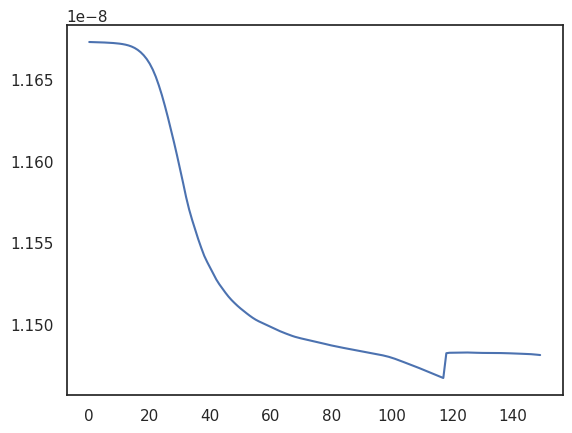

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.2396767462055095e-08, GW-cost: 1.6067415990269527e-12, Total cost: 1.2396767462055095e-08
Final Wasserstein cost: 1.2266012636943631e-08, GW-cost: 1.595880975988233e-12, Total cost: 1.2266012636943631e-08


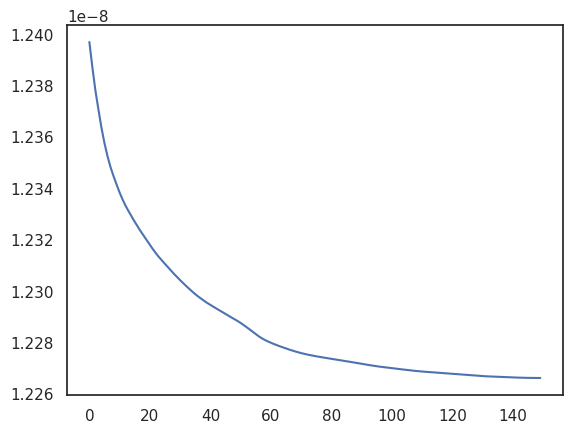

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 9.001064791158025e-09, GW-cost: 6.758601757533626e-13, Total cost: 9.001064791158025e-09
Final Wasserstein cost: 8.400879792638526e-09, GW-cost: 6.411278050686064e-13, Total cost: 8.400879792638526e-09


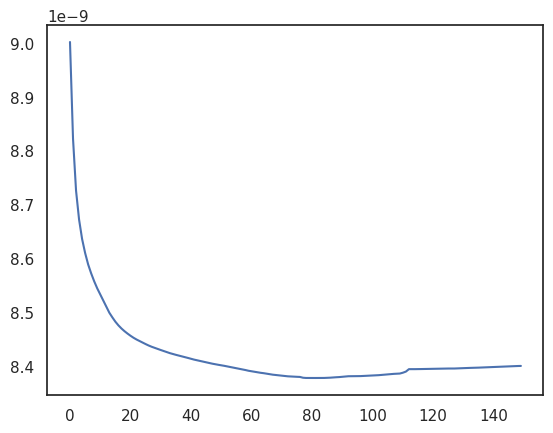

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.0633109993263772e-08, GW-cost: 5.823662353352632e-13, Total cost: 1.0633109993263772e-08
Final Wasserstein cost: 9.639400359731962e-09, GW-cost: 5.489086275532989e-13, Total cost: 9.639400359731962e-09


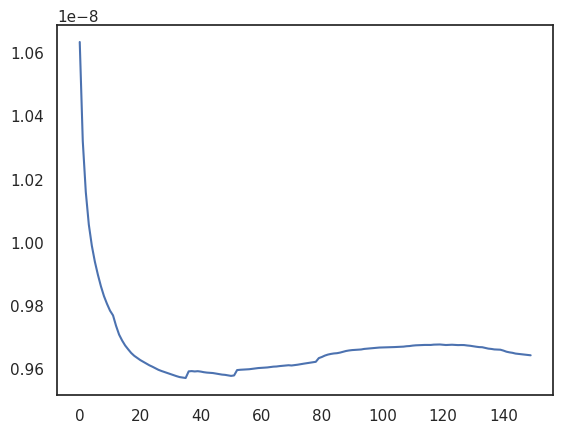

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.3750156596777474e-08, GW-cost: 5.4645481874045e-13, Total cost: 1.3750156596777474e-08
Final Wasserstein cost: 1.0868342677318994e-08, GW-cost: 3.931944083131105e-13, Total cost: 1.0868342677318994e-08


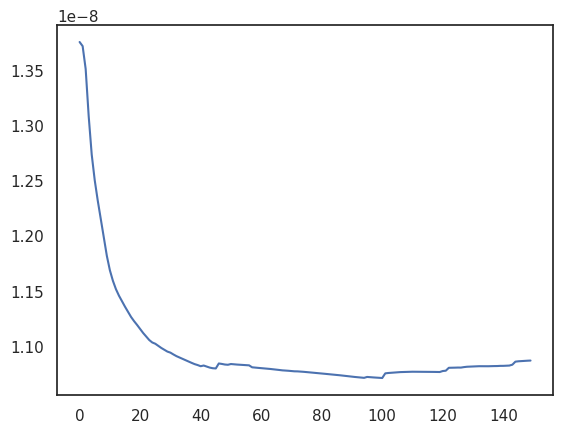

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.0853462229299488e-08, GW-cost: 6.03536214838504e-13, Total cost: 1.0853462229299488e-08
Final Wasserstein cost: 9.391180014875815e-09, GW-cost: 5.610981925324499e-13, Total cost: 9.391180014875815e-09


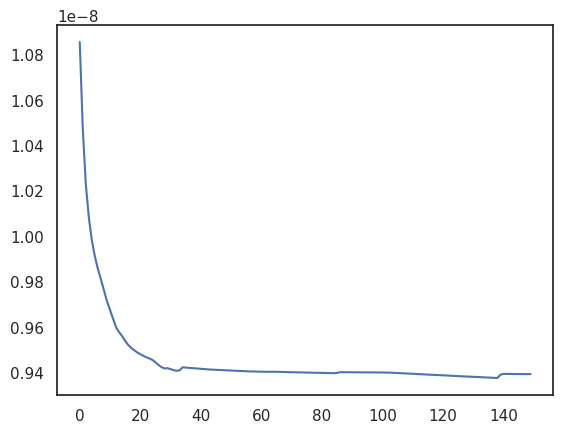

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 8.946016020039994e-09, GW-cost: 6.819978946916816e-13, Total cost: 8.946016020039994e-09
Final Wasserstein cost: 7.574281493135745e-09, GW-cost: 5.610240567461328e-13, Total cost: 7.574281493135745e-09


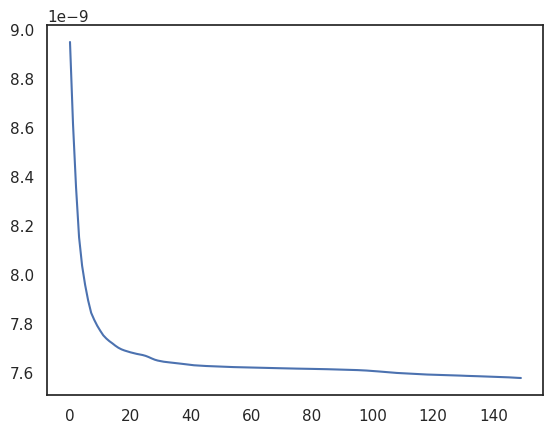

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.232368247963744e-08, GW-cost: 1.6030403203836359e-12, Total cost: 1.232368247963744e-08
Final Wasserstein cost: 1.190091881917254e-08, GW-cost: 1.31534290531729e-12, Total cost: 1.190091881917254e-08


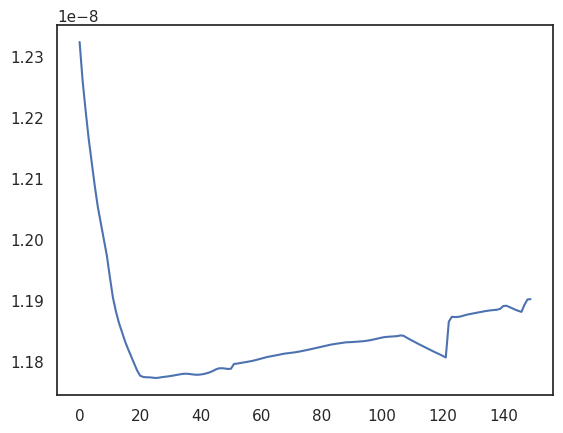

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.1495290095664054e-08, GW-cost: 4.409107295513075e-12, Total cost: 1.1495290095664054e-08
Final Wasserstein cost: 1.1423524648883576e-08, GW-cost: 4.213484667025841e-12, Total cost: 1.1423524648883576e-08


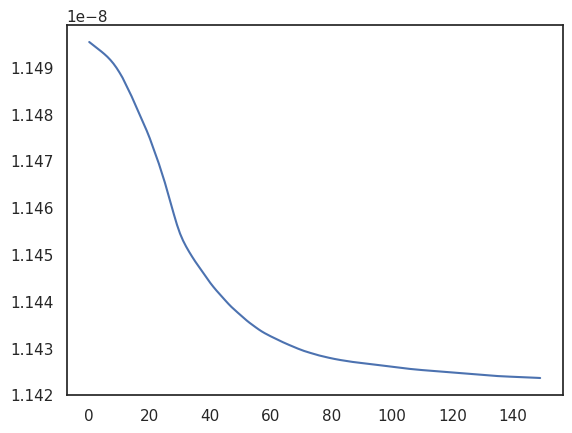

Ranks: r1 2, r2 9, r3 8
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein-sum cost: 2.399168869412052e-08
Final Wasserstein-sum cost: 2.3514855772247322e-08


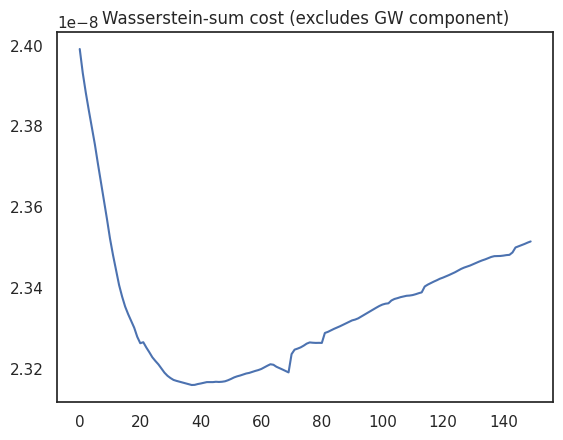

Ranks: r1 9, r2 8, r3 12
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein-sum cost: 2.1477700996756608e-08
Final Wasserstein-sum cost: 1.9868763818122827e-08


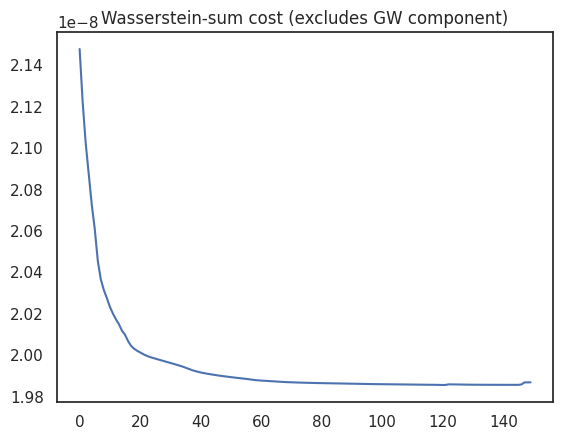

Ranks: r1 8, r2 12, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein-sum cost: 2.009752237346691e-08
Final Wasserstein-sum cost: 1.8035317910442715e-08


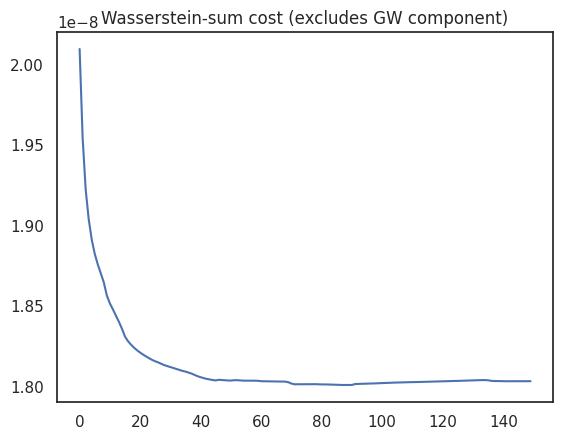

Ranks: r1 12, r2 14, r3 23
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein-sum cost: 2.4106196616375715e-08
Final Wasserstein-sum cost: 2.1438718278667878e-08


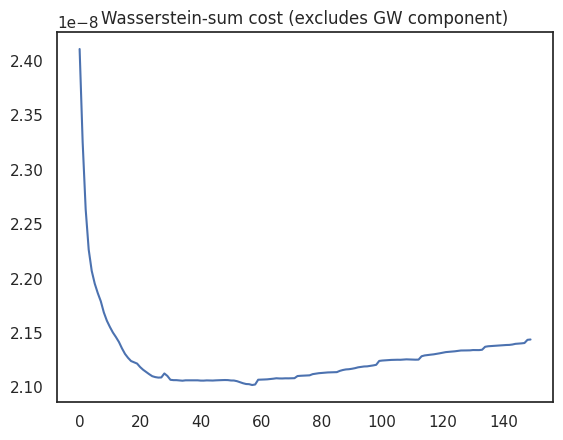

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.1435008693597123e-08, GW-cost: 4.1492700543136825e-12, Total cost: 1.1435008693597123e-08
Final Wasserstein cost: 1.1434999640561787e-08, GW-cost: 4.149490380339377e-12, Total cost: 1.1434999640561787e-08


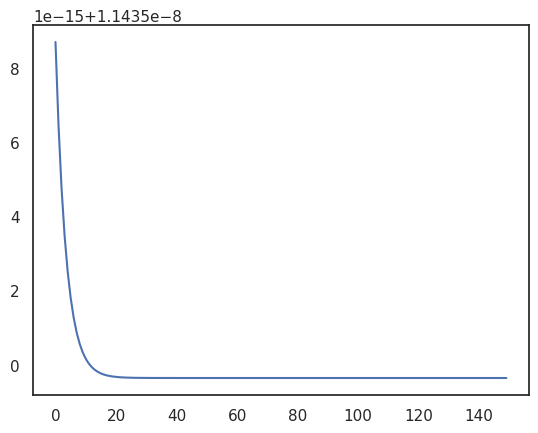

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.231262236828003e-08, GW-cost: 1.5449991635046144e-12, Total cost: 1.231262236828003e-08
Final Wasserstein cost: 1.2084901565746453e-08, GW-cost: 1.472047062764228e-12, Total cost: 1.2084901565746453e-08


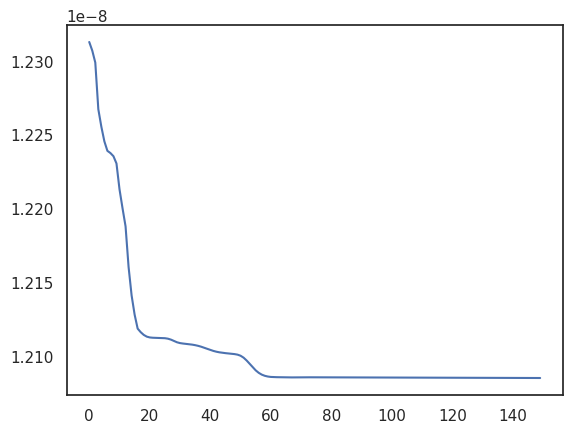

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 9.238837505637044e-09, GW-cost: 7.068750636532036e-13, Total cost: 9.238837505637044e-09
Final Wasserstein cost: 7.733058405675236e-09, GW-cost: 5.837960094033174e-13, Total cost: 7.733058405675236e-09


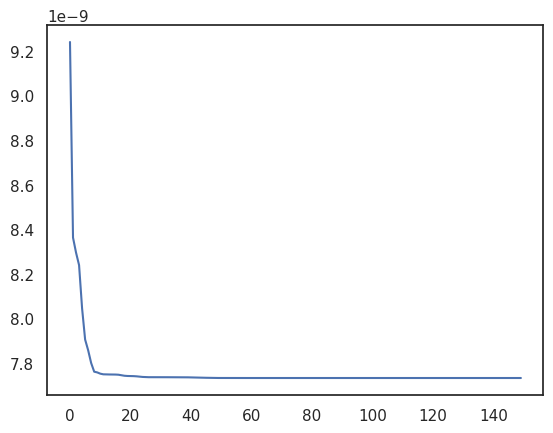

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.0728349966037118e-08, GW-cost: 6.188059128959784e-13, Total cost: 1.0728349966037118e-08
Final Wasserstein cost: 9.693364496760623e-09, GW-cost: 5.623191808687237e-13, Total cost: 9.693364496760623e-09


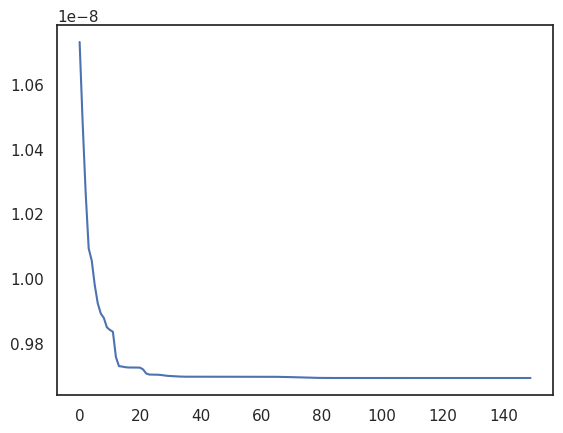

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Initial Wasserstein cost: 1.2770457629458272e-08, GW-cost: 5.607954941362323e-13, Total cost: 1.2770457629458272e-08
Final Wasserstein cost: 1.1534288307073394e-08, GW-cost: 5.022650187669256e-13, Total cost: 1.1534288307073394e-08


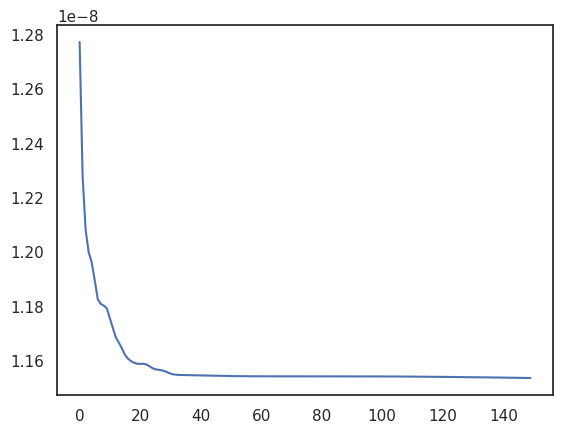

CPU times: user 8min 37s, sys: 4.56 s, total: 8min 41s
Wall time: 8min 36s


In [72]:
%%time
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)


WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

Qs_pred = [Q.cpu().numpy() for Q in WDM.Q_gammas]
Ts_pred = [T.cpu().numpy() for T in WDM.T_gammas]

## plot

In [136]:
importlib.reload(clustering)

<module 'clustering' from '/content/drive/Othercomputers/numac/GitHub/WDM/clustering.py'>

In [135]:
Ss = spatial_list

node_labels1 = [None for Q in WDM.Q_gammas]

clustering.plot_clusters_from_QT(Ss, Qs_pred, Ts_pred, node_labels1, dotsize=10)
clustering.diffmap_from_QT(Qs_pred, Ts_pred, cell_type_labels=node_labels1, dsf=.3, stretch=1.5)
clustering.diffmap_from_QT_sankey(Qs_pred, Ts_pred, cell_type_labels=node_labels1, dsf=.3, plot_height=1000)

Output hidden; open in https://colab.research.google.com to view.

In [128]:
importlib.reload(clustering)

<module 'clustering' from '/content/drive/Othercomputers/numac/GitHub/WDM/clustering.py'>

## save

In [76]:
for i,Q in enumerate(WDM.Q_gammas):
    np.save(filehandle_save + f'wdm_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM.T_gammas):
    np.save(filehandle_save + f'wdm_T{i}{i+1}.npy', T.cpu().numpy())

## ari, ami

In [77]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [78]:
gt_types_list = clustering.max_likelihood_clustering(Qs_gt)
pred_types_list = clustering.max_likelihood_clustering(Qs_pred)

util_zf.compute_ARI_and_AMI(gt_types_list, pred_types_list)

ARI and AMI of predictions (filtered excludes ground truth clusters smaller than 5% of the data)

ARI for 0th slice is 0.575 (filtered: 0.575) 	
AMI for 0th slice is 0.491 (filtered: 0.491)


ARI for 1th slice is 0.087 (filtered: 0.108) 	
AMI for 1th slice is 0.262 (filtered: 0.281)


ARI for 2th slice is 0.331 (filtered: 0.348) 	
AMI for 2th slice is 0.482 (filtered: 0.491)


ARI for 3th slice is 0.220 (filtered: 0.242) 	
AMI for 3th slice is 0.373 (filtered: 0.384)


ARI for 4th slice is 0.309 (filtered: 0.357) 	
AMI for 4th slice is 0.468 (filtered: 0.471)


ARI for 5th slice is 0.212 (filtered: 0.230) 	
AMI for 5th slice is 0.457 (filtered: 0.476)




In [79]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [80]:
# util_zf.silhouette(gt_types_list, pred_types_list, Xs, Ss)

In [81]:
# util_zf.cos_silhouette(gt_types_list, pred_types_list, Xs, Ss)

## freezing $Q$s with annotations, running `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.1673438317592772e-08, GW-cost: 3.3579448905344985e-12, Total cost: 1.1673438317592772e-08
Final Wasserstein cost: 1.1647684829864582e-08, GW-cost: 3.4430120896371826e-12, Total cost: 1.1647684829864582e-08


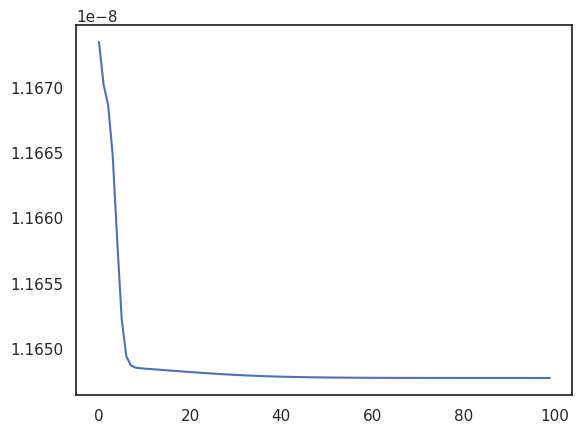

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.2342976828179771e-08, GW-cost: 1.2898562347569434e-12, Total cost: 1.2342976828179771e-08
Final Wasserstein cost: 1.2072672773311365e-08, GW-cost: 1.3386628326584736e-12, Total cost: 1.2072672773311365e-08


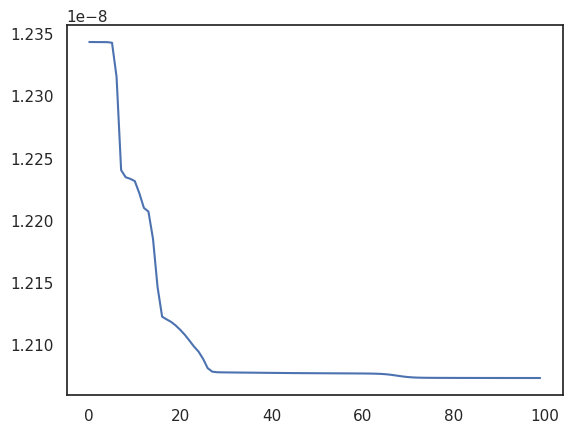

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 9.01965285407811e-09, GW-cost: 5.657478294820901e-13, Total cost: 9.01965285407811e-09
Final Wasserstein cost: 7.81468414247593e-09, GW-cost: 4.0903007414357743e-13, Total cost: 7.81468414247593e-09


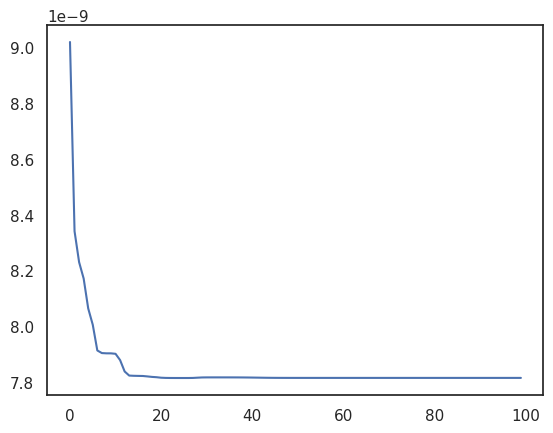

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.169656205733504e-08, GW-cost: 5.731795662762422e-13, Total cost: 1.169656205733504e-08
Final Wasserstein cost: 9.617391500584684e-09, GW-cost: 4.901324771896669e-13, Total cost: 9.617391500584684e-09


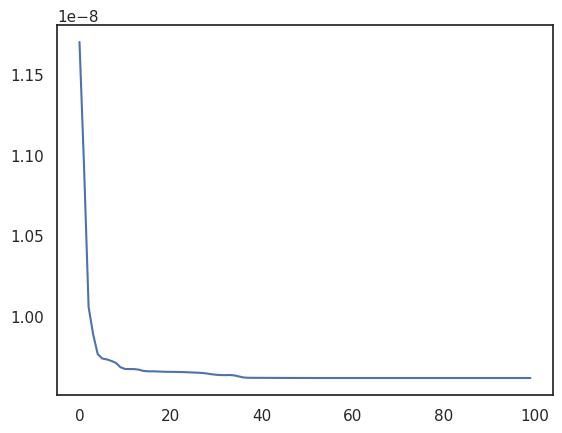

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.2483130681429286e-08, GW-cost: 5.00685098136273e-13, Total cost: 1.2483130681429286e-08
Final Wasserstein cost: 1.1611783768208103e-08, GW-cost: 4.0751878953735087e-13, Total cost: 1.1611783768208103e-08


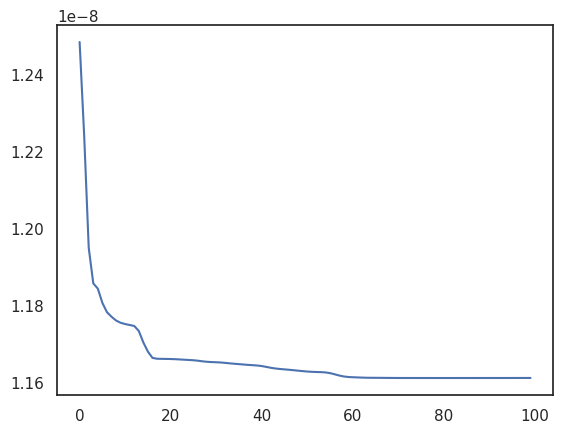

CPU times: user 1min 11s, sys: 1.13 s, total: 1min 12s
Wall time: 1min 11s


In [82]:
%%time
Q_annot = Qs_gt_tensor

importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=100, min_iter=100, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args=None)

WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)
T_gammas = WDM2.T_gammas

In [83]:
for i,Q in enumerate(WDM2.Q_gammas):
    np.save(filehandle_save + f'ann_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM2.T_gammas):
    np.save(filehandle_save + f'ann_T{i}{i+1}.npy', T.cpu().numpy())

# Analysis part 1: entropy of transitions

In [84]:
Ts_ann = T_gammas
Ts_pred = Ts_pred

## entropy functions

In [85]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [86]:
print('Comparing entropies with annotations\n')

util_zf.compare_T_entropies(Ts_ann, Ts_pred)
print('\n')
util_zf.compare_T_col_entropies(Ts_ann, Ts_pred)
print('\n')
util_zf.compare_T_row_entropies(Ts_ann, Ts_pred)

Comparing entropies with annotations

Pred transitions 0 -> 1 are **MORE** entropic: 2.017 > 1.845
Pred transitions 1 -> 2 are **MORE** entropic: 2.604 > 2.308
Pred transitions 2 -> 3 are **MORE** entropic: 2.821 > 2.445
Pred transitions 3 -> 4 are **MORE** entropic: 2.996 > 2.553
Pred transitions 4 -> 5 are **MORE** entropic: 3.352 > 2.997


Pred transitions 0 -> 1 have **LESS** column entropy: 0.453 < 0.644
Pred transitions 1 -> 2 have **MORE** column entropy: 4.561 > 2.874
Pred transitions 2 -> 3 have **MORE** column entropy: 3.972 > 2.700
Pred transitions 3 -> 4 have **MORE** column entropy: 5.177 > 4.644
Pred transitions 4 -> 5 have **MORE** column entropy: 6.280 > 5.770


Pred transitions 0 -> 1 have **LESS** row entropy: 2.465 < 2.526
Pred transitions 1 -> 2 have **LESS** row entropy: 2.585 < 2.785
Pred transitions 2 -> 3 have **MORE** row entropy: 5.980 > 3.717
Pred transitions 3 -> 4 have **MORE** row entropy: 6.349 > 4.292
Pred transitions 4 -> 5 have **LESS** row entropy: 8.

## convergence / collision

In [87]:
Ts_moscot = []

for i in range(5):
    Pi = np.load(filehandle_load_moscot + f'moscot_Pi_{i}.npy')
    Q1 = Qs_gt[i]
    Q2 = Qs_gt[i+1]
    T = ((Q1.T @ Pi) @ Q2) * (Q1.shape[0]*Q2.shape[0])
    Ts_moscot += [T]

In [88]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [89]:
print('Comparing entropies with moscot\n')

Ts_moscot_tens = [ torch.Tensor(T) for T in Ts_moscot ]

util_zf.compare_T_entropies(Ts_moscot_tens, Ts_pred)
print('\n')
util_zf.compare_T_col_entropies(Ts_moscot_tens, Ts_pred)
print('\n')
util_zf.compare_T_row_entropies(Ts_moscot_tens, Ts_pred)

Comparing entropies with moscot

Pred transitions 0 -> 1 are **MORE** entropic: 2.017 > 1.796
Pred transitions 1 to 2 are **LESS** entropic: 2.604 < 2.956
Pred transitions 2 -> 3 are **MORE** entropic: 2.821 > 2.608
Pred transitions 3 -> 4 are **MORE** entropic: 2.996 > 2.675
Pred transitions 4 -> 5 are **MORE** entropic: 3.352 > 3.132


Pred transitions 0 -> 1 have **LESS** column entropy: 0.453 < 4.491
Pred transitions 1 -> 2 have **LESS** column entropy: 4.561 < 9.921
Pred transitions 2 -> 3 have **LESS** column entropy: 3.972 < 5.262
Pred transitions 3 -> 4 have **LESS** column entropy: 5.177 < 8.933
Pred transitions 4 -> 5 have **LESS** column entropy: 6.280 < 14.354


Pred transitions 0 -> 1 have **LESS** row entropy: 2.465 < 2.732
Pred transitions 1 -> 2 have **LESS** row entropy: 2.585 < 11.296
Pred transitions 2 -> 3 have **MORE** row entropy: 5.980 > 5.503
Pred transitions 3 -> 4 have **LESS** row entropy: 6.349 < 7.445
Pred transitions 4 -> 5 have **LESS** row entropy: 8.248

In [90]:
importlib.reload(util_zf)

'''
for i, (T_pred, T_ann, T_moscot) in enumerate(zip(Ts_pred, Ts_ann, Ts_moscot)):
    T_ann = T_ann.cpu().numpy()
    util_zf.plot_collision_profiles([T_pred,
                                     T_ann,
                                     T_moscot],
                                    title=f'Collision / convergence profiles at snapshot {i+2}',
                                    label_list=['HM-OT', 'Anno', 'moscot'])
''';

## anno diffmap

In [143]:
importlib.reload(clustering)

<module 'clustering' from '/content/drive/Othercomputers/numac/GitHub/WDM/clustering.py'>

In [146]:
clustering.plot_clusters_from_QT(Ss, Qs_gt, Ts_ann, None, dotsize=10)
clustering.diffmap_from_QT(Qs_gt, Ts_ann, cell_type_labels=ct_labels, dsf=.3, stretch=1.5)
clustering.diffmap_from_QT_sankey(Qs_gt, [T.cpu().numpy() for T in Ts_ann], cell_type_labels=ct_labels, dsf=.3, plot_height=1000)

Output hidden; open in https://colab.research.google.com to view.

total number of tab colors that can be displayed: 60
total number of unique values: 68


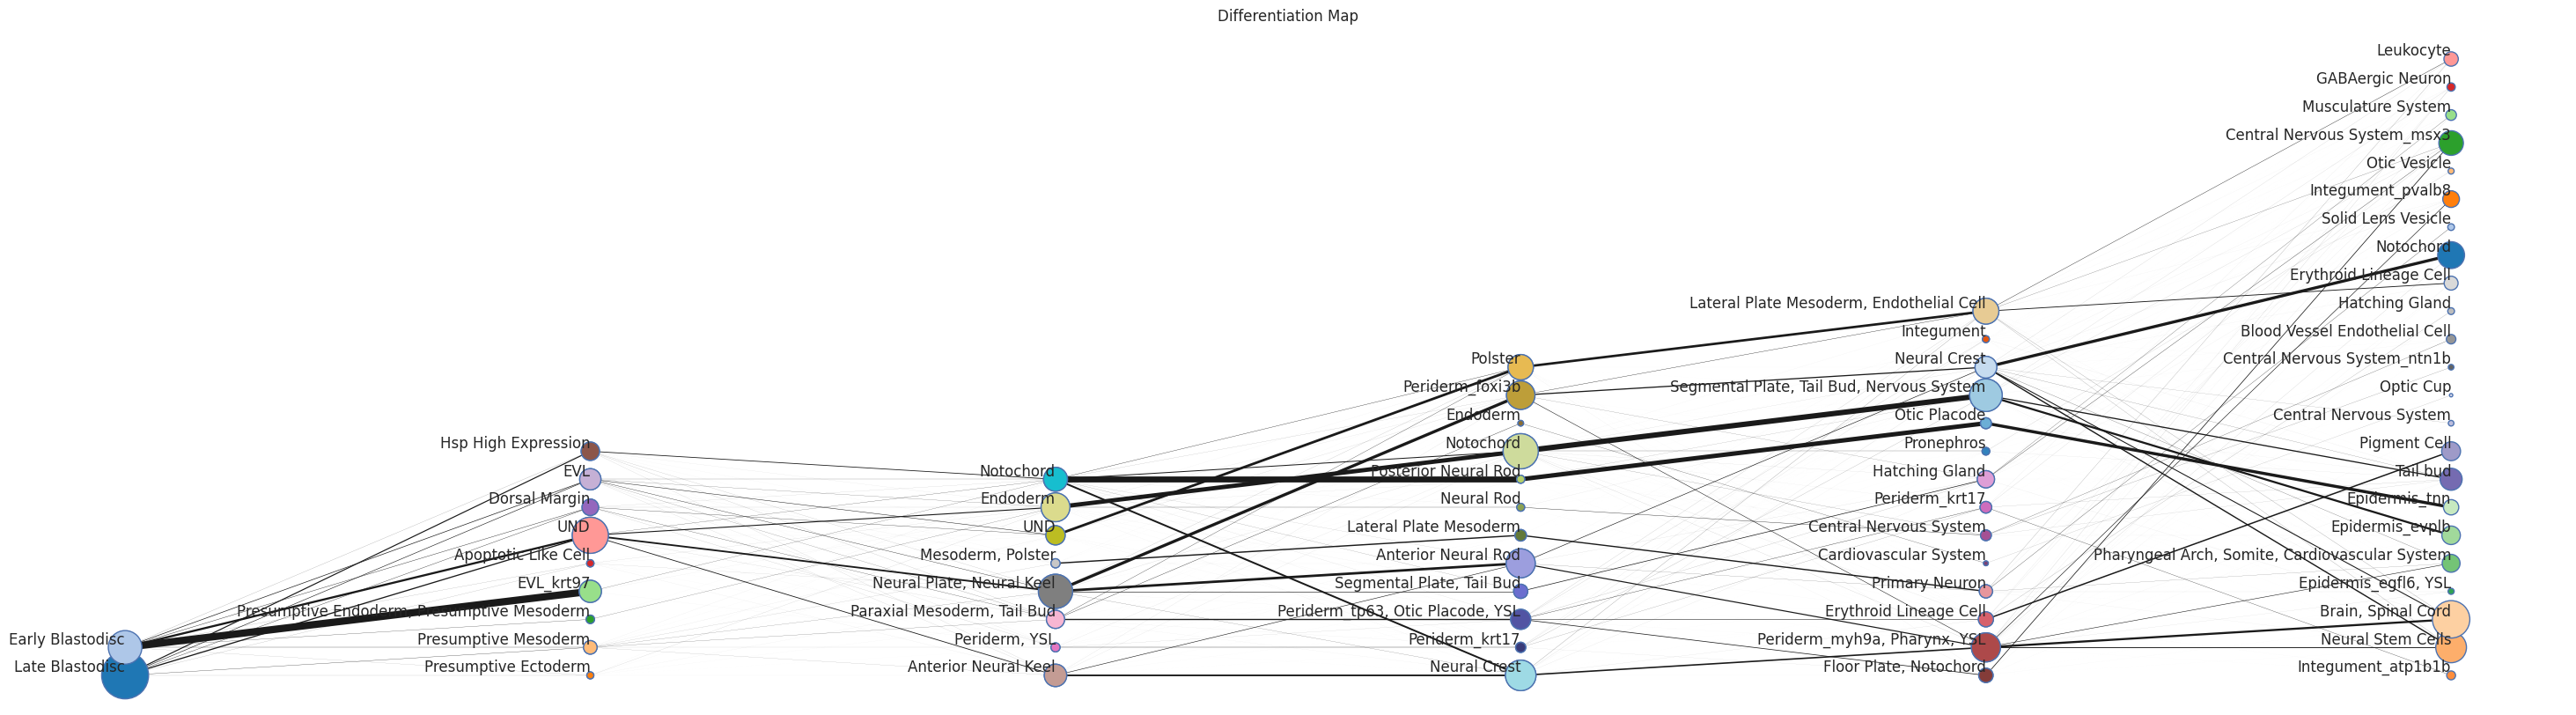

total number of tab colors that can be displayed: 60
total number of unique values: 68


In [138]:
clustering.diffmap_from_QT(Qs_gt, Ts_moscot, cell_type_labels=ct_labels, dsf=.3, stretch=1.5)
clustering.diffmap_from_QT_sankey(Qs_gt, Ts_moscot, cell_type_labels=ct_labels, dsf=.3, plot_height=1000)

## independence ratio

In [93]:
def independence_ratio(T12, T23, g_Q2, g_Q1, g_Q3, labels1, labels3, diagonal=False):
    ct_to_IR = { }
    set1, set3 = set(labels1), set(labels3)
    labels_intersection = set1.intersection(set3)
    for label in labels_intersection:
        idx_k = labels1.index(label)
        idx_l = labels3.index(label)
        #print(f'{label}: {idx_k} to {idx_l}')
        vec = (T12[idx_k, :] * T23[:, idx_l]) / g_Q2
        ct_to_IR[label] = torch.sum(vec) / (g_Q1[idx_k] * g_Q3[idx_l])
    return ct_to_IR

## Peter's desired trajectories + UMAP plot

In [94]:
ranks

[(2, 9), (9, 8), (8, 12), (12, 14), (14, 23)]

In [95]:
sizes = [2, 9, 8, 12, 14, 23]

In [96]:
import numpy as np

def normalize_to_row_stochastic(Ts):
    """
    Normalize a list of coupling matrices to be row-stochastic (i.e., each row sums to 1).

    Args:
        Ts (list of np.ndarray): A list of coupling matrices (2D numpy arrays).

    Returns:
        normalized_Ts (list of np.ndarray): A list of normalized row-stochastic coupling matrices.
    """
    normalized_Ts = []

    first_marginal = Ts[0].sum(axis=1, keepdims=False)

    for T in Ts:
        # Normalize each row of the matrix to sum to 1
        row_sums = T.sum(axis=1, keepdims=False)
        print(f'row_sums shape: {row_sums.shape}')
        print(f'T shape: {T.shape}')
        # Handle any rows that sum to zero by avoiding division by zero
        normalized_T = np.diag(1/row_sums) @ T
        normalized_Ts.append(normalized_T)

    return first_marginal, normalized_Ts


# for now, sample according to Ts, in future we can specify an initial cluster or even initial point
def sample_latent_trajectories(Ts_rs, g_init, sizes, num_trajectories=10):
    """
    Sample trajectories from the given latent coupling matrices Ts.

    Args:
        Ts_rs (list of np.ndarray): A list of coupling matrices T_t for t = 1, ..., N-1.
                                    These should be row-stochastic, but we ensure they are normalized.
        g_init (np.ndarray): The initial distribution over states.
        sizes (list of int): The sizes of the state spaces at each timepoint.
        num_trajectories (int): Number of trajectories to sample.

    Returns:
        trajectories (np.ndarray): An array of sampled trajectories of shape (num_trajectories, N).
    """
    N = len(sizes)  # Number of timepoints
    trajectories = np.zeros((num_trajectories, N), dtype=int)

    # Normalize initial distribution
    g_init = g_init / np.sum(g_init)

    # Sample initial state
    trajectories[:, 0] = np.random.choice(sizes[0], num_trajectories, p=g_init)

    # Sample subsequent states
    for t in range(1, N):
        for i in range(num_trajectories):
            prev_state = trajectories[i, t-1]
            # Normalize the row of Ts_rs corresponding to the previous state
            row = Ts_rs[t-1][prev_state]
            row = row / np.sum(row)  # Normalize to ensure it sums to 1
            # Sample next state based on the normalized row
            trajectories[i, t] = np.random.choice(sizes[t], p=row)

    return trajectories

In [97]:
g_init, Ts_rs = normalize_to_row_stochastic(Ts_pred)

g_init

traj_test = sample_latent_trajectories(Ts_rs=Ts_rs, g_init=g_init, sizes=sizes)
traj_test

row_sums shape: (2,)
T shape: (2, 9)
row_sums shape: (9,)
T shape: (9, 8)
row_sums shape: (8,)
T shape: (8, 12)
row_sums shape: (12,)
T shape: (12, 14)
row_sums shape: (14,)
T shape: (14, 23)


array([[ 1,  1,  4,  1,  2,  8],
       [ 1,  1,  4,  1,  9,  4],
       [ 1,  1,  7,  7,  8,  7],
       [ 0,  2,  3, 11, 12, 13],
       [ 1,  4,  5,  5,  2,  6],
       [ 0,  8,  5,  9,  5, 22],
       [ 0,  0,  6,  6,  4, 11],
       [ 0,  5,  3,  8,  2,  8],
       [ 1,  1,  3,  8,  2,  6],
       [ 0,  1,  7,  4,  8,  2]])

## what about arg-secondmax? Does this have biological signal?

In [98]:
labels_2nd = []

for Q in Qs_pred:
    # Get the indices of the sorted entries for each row
    sorted_indices = np.argsort(Q, axis=1)

    # Extract the second-to-last index (the second largest) from the sorted indices
    second_largest_indices = sorted_indices[:, -2]
    labels_2nd += [second_largest_indices]

In [99]:
threshold = 0.1  # Example threshold as a percentage of the largest value

labels_consensus = []

for Q in Qs_pred:
    argmax_labels = np.argmax(Q, axis=1)
    sorted_indices = np.argsort(Q, axis=1)
    second_argmax_labels = sorted_indices[:, -2]

    # Get the largest and second largest values from Q
    largest_values = np.max(Q, axis=1)
    second_largest_values = Q[np.arange(Q.shape[0]), second_argmax_labels]

    # Apply the threshold to choose between argmax and second argmax
    consensus_labels = np.where((largest_values - second_largest_values) / largest_values < threshold,
                                second_argmax_labels, argmax_labels)

    # Convert consensus_labels (NumPy array) to a regular Python list of ints
    labels = consensus_labels.tolist()  # Convert the array to a list
    labels = [int(label) for label in labels]  # Ensure all elements are ints
    labels = np.array(labels)
    labels_consensus.append(labels)  # Use append to add the new list of labels

# Now labels_consensus is a list of lists, suitable for plotting
clustering.plot_clustering_list(Ss, labels_consensus, dotsize=10)

Output hidden; open in https://colab.research.google.com to view.

In [100]:
util_zf.compute_ARI_and_AMI(gt_types_list, labels_consensus)

ARI and AMI of predictions (filtered excludes ground truth clusters smaller than 5% of the data)

ARI for 0th slice is 0.574 (filtered: 0.574) 	
AMI for 0th slice is 0.491 (filtered: 0.491)


ARI for 1th slice is 0.087 (filtered: 0.108) 	
AMI for 1th slice is 0.262 (filtered: 0.281)


ARI for 2th slice is 0.331 (filtered: 0.348) 	
AMI for 2th slice is 0.482 (filtered: 0.491)


ARI for 3th slice is 0.220 (filtered: 0.242) 	
AMI for 3th slice is 0.373 (filtered: 0.384)


ARI for 4th slice is 0.310 (filtered: 0.357) 	
AMI for 4th slice is 0.468 (filtered: 0.471)


ARI for 5th slice is 0.212 (filtered: 0.230) 	
AMI for 5th slice is 0.457 (filtered: 0.476)


